In [13]:
from abenc_ph_mj18 import PH_ABE, mat_math, Inner_Product
from charm.toolbox.pairinggroup import PairingGroup, ZR, G1, G2, GT, pair
from charm.toolbox.ABEnc import ABEnc
from nizk import NIZK
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def ad_auth_setup(n, assump_size, ad, pks):
    pk_ad = []
    k = assump_size
    pk_ad = [[1] * k] * (k+1)

    for i in range(n-1):
        if i + 1 == ad:
            continue
        g_XTA = pks[str(i+1)]['g_1^{X^T A}']

        tmp = []
        for j in range(len(g_XTA)):
            tmp.append([x / y for x,y in zip(pk_ad[j], g_XTA[j])])
        pk_ad = tmp

    pk = pks[str(ad)]
    pk['g_1^{X^T A}'] = pk_ad
    pks[str(ad)] = pk
    return pks

def gen_omega(K, C, n, assump_size):
    H = K['g_2^h']
    k = assump_size
    C_i_s = C['C_i']

    C_ = [1] * (k + 1)
    for i in range(n-1):
        C_ = [x / y for x,y in zip(C_, C_i_s[i])]

    return [pair(x,y) for x,y in zip(C_, H)]


In [8]:
def benchmark_scheme(assump_size, list_n, groupObj = PairingGroup('MNT224')):
    k = assump_size
    group = groupObj
    result = []
    math_lib = mat_math()

    for n in list_n:
        print ("----------------", n, "-----------------------")
        scheme_cost = []
        ad_cost = []
        defense_cost = []
        ph_abe = PH_ABE(n, assump_size, group, math_lib)
        attributes = Inner_Product(group)   
        nizk = NIZK(group)
        # sys setup
        start_time = time.time()
        pp, msk = ph_abe.setup()
        elapsed_time = time.time() - start_time
        scheme_cost.append(elapsed_time)

        # Auth setup
        start_time = time.time()
        pks, sks = ph_abe.auth_setup(pp)
        elapsed_time = time.time() - start_time
        scheme_cost.append(elapsed_time)

        # Worst Case
        start_time = time.time()
        for i in range(n):
            s_pairs, pis = nizk.commit_pk(pp, pks[str(i+1)], sks[str(i+1)])
            check = nizk.verify_pk(pp, s_pairs, pis)
            if not check:
                print ("Check not pass for AA:", str(i+1))
                break
        elapsed_time = time.time() - start_time
        defense_cost.append(elapsed_time)

        # Key Gen
        start_time = time.time()
        vec_x, vec_v = attributes.gen_x_v(n, assump_size)
        K = ph_abe.keygen(pp, sks, vec_v)
        elapsed_time = time.time() - start_time
        scheme_cost.append(elapsed_time)

        # AD's setup
        start_time = time.time()

        ad = vec_v.index(0) + 1
        ad_vec_v = [0] * (n-1) + [1]
        print ('Authorized list: ', vec_v)
        print ('Adversary:', ad, '\nVector belongs to AD:', ad_vec_v)
        pks = ad_auth_setup(n, assump_size, ad, pks)

        elapsed_time = time.time() - start_time
        ad_cost.append(elapsed_time)

        # random case
        start_time = time.time()
        for i in range(n):
            s_pairs, pis = nizk.commit_pk(pp, pks[str(i+1)], sks[str(i+1)])
            check = nizk.verify_pk(pp, s_pairs, pis)
            if not check:
                print ("Check not pass for AA:", str(i+1))
                break
        elapsed_time = time.time() - start_time
        defense_cost.append(elapsed_time)

        # Encryption
        start_time = time.time()
        M = group.random(GT)
        print ('M:', M)
        C, vec_s = ph_abe.encrypt(pp, pks, vec_x, M)
        elapsed_time = time.time() - start_time
        #print (elapsed_time)
        scheme_cost.append(elapsed_time)

        # Decryption
        start_time = time.time()
        M_ = ph_abe.decrypt(K, C, vec_v, pp)
        print ('M_ (Usr):', M_)
        elapsed_time = time.time() - start_time
        scheme_cost.append(elapsed_time)

        # AD decrypt
        start_time = time.time()
        K_ = ph_abe.keygen(pp, sks, ad_vec_v)
        omega = gen_omega(K_,C,n,assump_size)
        
        M_ = ph_abe.decrypt(K_, C, ad_vec_v, pp) * math_lib.prod(omega)
        print ('M_ (Adv):', M_)
        elapsed_time = time.time() - start_time
        ad_cost.append(elapsed_time)

        result.append([scheme_cost, ad_cost, defense_cost])

    return result
        

In [14]:
def plot_total_time_changes(xs, ys, k_values, sp_ks, sp_xs, sp_ys):
    # Plotting:
    plt.figure(figsize=(10,6))

    # List of linestyles for variation. You can extend this if needed.
    linestyles = ['-', '-.']
    sp_linestyles = ['--',':']

    # Plotting the regular data points for each k_value
    for k, y, style in zip(k_values, ys, linestyles):
        plt.plot(xs, y, label=f'k={k}', linestyle=style)

    # Plotting the special cases
    for k, y, style in zip(sp_ks, sp_ys, sp_linestyles):
        plt.plot(sp_xs, y, linestyle=style, marker='o', label=f'Special k={k}')

    vlines_x = [45, 85]  # example x-coordinates for the vertical lines

    for vx in vlines_x:
        plt.axvline(x=vx, color='gray', linestyle='--', alpha=0.7)  # draw vertical line
        
        if vx in xs:  # If vx is a value in xs, get its intersection with the regular plots
            idx = xs.index(vx)
            for y in ys:
                rounded_y = round(y[idx], 2)
                plt.scatter(vx, rounded_y, color='red', zorder=5)
                plt.annotate(f'({vx}, {rounded_y})', (vx, rounded_y), textcoords="offset points", xytext=(0,10), ha='center')
        
        if vx in sp_xs:  # If vx is a value in sp_x, get its intersection with the special plots
            idx_sp = sp_xs.index(vx)
            for y in sp_ys:
                rounded_y_sp = round(y[idx_sp], 2)
                plt.scatter(vx, rounded_y_sp, color='blue', zorder=5)
                plt.annotate(f'({vx}, {rounded_y_sp})', (vx, rounded_y_sp), textcoords="offset points", xytext=(0,10), ha='center')

    # Setting labels, title, legend, etc.
    plt.xlabel('Size of attribute authority')
    plt.ylabel('Elapsed Time (seconds)')
    #plt.title('Performance based on k-LIN Assumption Size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Benchmarking

In [15]:
xs = range(5,101,5)
k_values = [2,3]

data_2 = benchmark_scheme(2, xs)
data_3 = benchmark_scheme(3, xs)

ys = []
ys.append([sum(pair[0]) for pair in data_2])
ys.append([sum(pair[0]) for pair in data_3])

---------------- 5 -----------------------
Authorized list:  [1, 1, 1, 0, 1]
Adversary: 4 
Vector belongs to AD: [0, 0, 0, 0, 1]
False for X in index:  0 0
Check not pass for AA: 4
M: [[13136588368886131944199152642996046534475658759655347029833910403074, 897072881266026955509560345718031245472622119556086398531416081055, 1890387413368425848038554613058274097527836649545926463273785975901], [12968812232272531648008154508609096419124672575515496563783914743934, 9717958073859264939158643829314499042846651956335089879423485932222, 14878763141003422398151471853164744209119836637837105791247391388076]]
M_ (Usr): [[13136588368886131944199152642996046534475658759655347029833910403074, 897072881266026955509560345718031245472622119556086398531416081055, 1890387413368425848038554613058274097527836649545926463273785975901], [12968812232272531648008154508609096419124672575515496563783914743934, 9717958073859264939158643829314499042846651956335089879423485932222, 14878763141003422398151471853164744

In [16]:
sp_ks = [5,10]
sp_xs = range(5,102,8)

data_5 = benchmark_scheme(sp_ks[0], sp_xs)
data_10 = benchmark_scheme(sp_ks[1], sp_xs)

sp_ys = []
sp_ys.append([sum(pair[0]) for pair in data_5])
sp_ys.append([sum(pair[0]) for pair in data_10])

---------------- 5 -----------------------
Authorized list:  [1, 0, 0, 0, 1]
Adversary: 2 
Vector belongs to AD: [0, 0, 0, 0, 1]
False for X in index:  0 0
Check not pass for AA: 2
M: [[11086559347955486366717117673305049224957096062961626252030688213152, 14933803868701808910821690106628089501348723000186940301202469778471, 8587887372636027756206459427938726199596008557715465791041368044791], [10904690393027787945829443313101809888477845978151408883512326678633, 1614318105771992378987774967986996413128189391144322482988694288488, 11824485473282134928781078215370939639048820433147560947989462649302]]
M_ (Usr): [[11086559347955486366717117673305049224957096062961626252030688213152, 14933803868701808910821690106628089501348723000186940301202469778471, 8587887372636027756206459427938726199596008557715465791041368044791], [10904690393027787945829443313101809888477845978151408883512326678633, 1614318105771992378987774967986996413128189391144322482988694288488, 1182448547328213492878107821537

## Ploting

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_secure_schemes(xs, ys, extra_costs, k_values):
    plt.figure(figsize=(10,6))
    linestyles = ['-', '-.']
    sp_linestyles = ['--', ':']

    # Ensure extra_costs has the same structure as ys
    assert len(ys) == len(extra_costs), "Each 'ys' must have a corresponding 'extra_costs' list."

    # Plotting the regular data points for each k_value and their adjusted times
    for k, y, extra, style in zip(k_values, ys, extra_costs, linestyles):
        adjusted_y = [original + extra for original, extra in zip(y, extra)]
        plt.plot(xs, y, label=f'Original k={k}', linestyle=style)
        plt.plot(xs, adjusted_y, label=f'Adjusted k={k}', linestyle=style, alpha=0.7)

        # Filling the area between the original and adjusted lines
        plt.fill_between(xs, y, adjusted_y, alpha=0.2, color='gray')

        # Annotating the percentage increase at specific points
        for xi, original, adj in zip(xs, y, adjusted_y):
            percentage_increase = ((adj - original) / original) * 100
            if percentage_increase > 0:
                plt.annotate(f'{percentage_increase:.2f}%', (xi, original + (adj - original)/2), textcoords="offset points", xytext=(0,5), ha='center')

    plt.xlabel('Size of attribute authority')
    plt.ylabel('Total Time Cost (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [54]:
xs = range(5,101,5)
k_values = [2,3]

ys = []
ys.append([sum(pair[0]) for pair in data_2])
#ys.append([pair[0][1] for pair in data_2])
#ys.append([sum(pair[0]) for pair in data_3])

extra_costs = []
extra_costs.append([pair[2][0] for pair in data_2])
#extra_costs.append([pair[2][0] for pair in data_3])

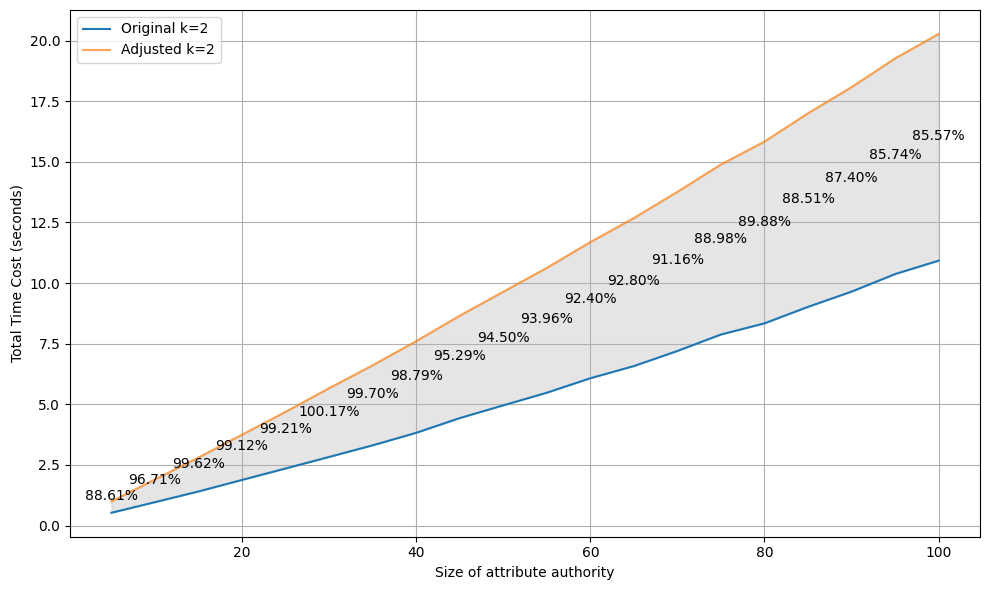

In [55]:
plot_secure_schemes(xs, ys, extra_costs,k_values)

In [46]:
xs = range(5,101,5)
k_values = [2,3]

ys = []
ys.append([sum(pair[0]) for pair in data_2])
#ys.append([pair[0][1] for pair in data_2])
#ys.append([sum(pair[0]) for pair in data_3])

extra_costs = []
extra_costs.append([pair[2][0] for pair in data_2])
#extra_costs.append([pair[2][0] for pair in data_3])

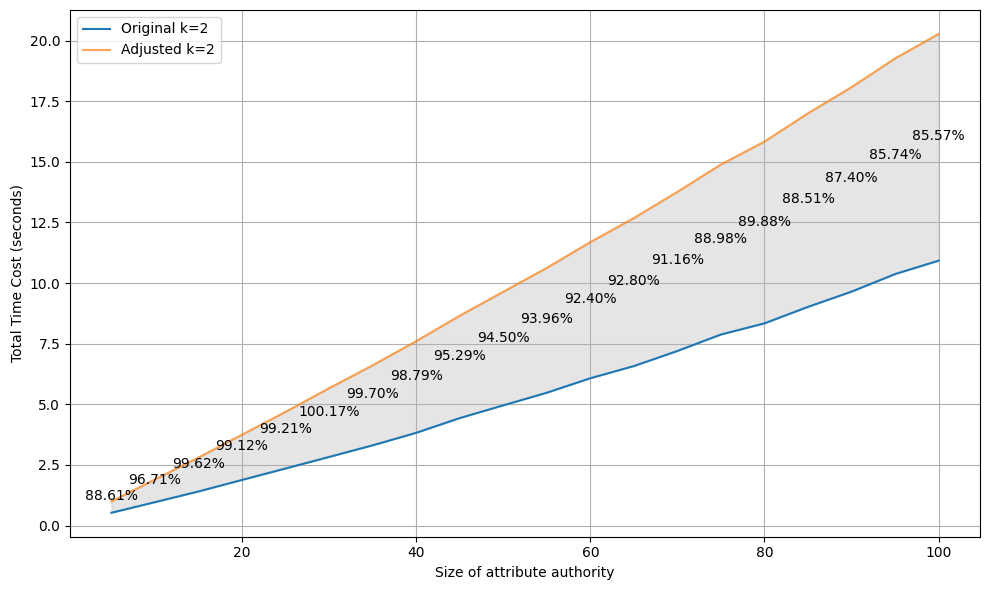

In [47]:
plot_secure_schemes(xs, ys, extra_costs,k_values)

In [39]:
xs = range(5,102,8)
ys = []
ys.append([sum(pair[0]) for pair in data_10])
#ys.append([pair[0][1] for pair in data_2])
#ys.append([sum(pair[0]) for pair in data_3])

extra_costs = []
extra_costs.append([pair[2][0] for pair in data_10])

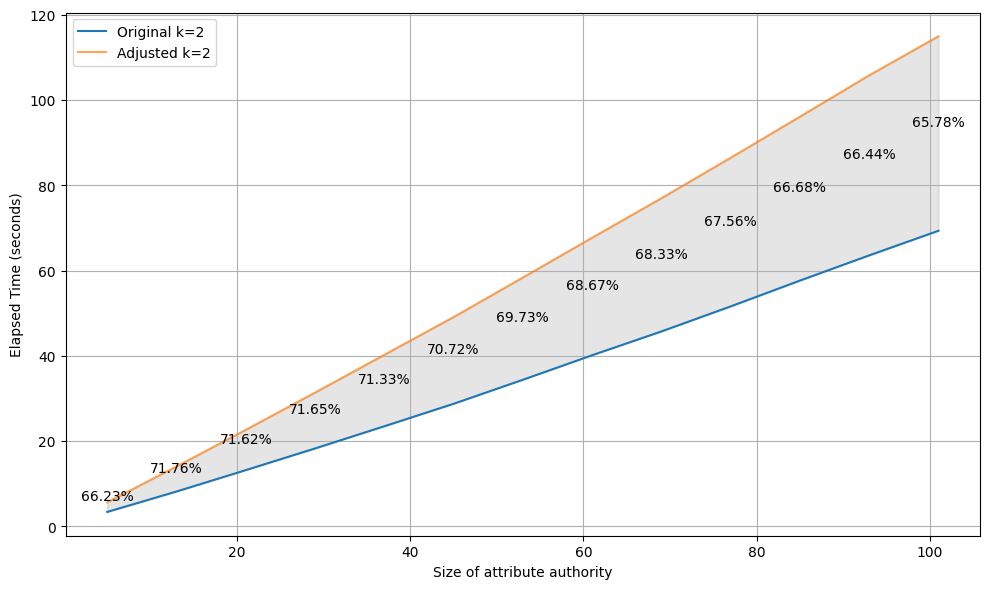

In [40]:
plot_secure_schemes(xs, ys, extra_costs,k_values)